In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import sys
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
GIT_ROOT = Path("../..").resolve()
SRC = GIT_ROOT / "src"
print(SRC)
if not SRC in sys.path:
    sys.path.append(str(SRC))
ratio = lambda t : t[0] / t[1]
print(torch.cuda.mem_get_info())
print(ratio(torch.cuda.mem_get_info()))

/home/ubuntu/anaconda3/envs/odl_torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/ubuntu/KEX---CT-reconstruction/src
(23138402304, 23827054592)
0.9710978843255256


In [2]:
from utils.data import get_htc2022_train_phantoms, get_htc_trainval_phantoms
from geometries import HTC2022_GEOMETRY

PHANTOMS, VALIDATION_PHANTOMS = get_htc_trainval_phantoms()
geometry = HTC2022_GEOMETRY
ar = 0.25
SINOS = geometry.project_forward(PHANTOMS)

print(PHANTOMS.shape)
print(SINOS.shape)
print(ratio(torch.cuda.mem_get_info()))

torch.Size([584, 512, 512])
torch.Size([584, 720, 560])
0.8007877394298791


In [4]:
from geometries.extrapolation import extrapolate_fixpoint, extrapolate_cgm
from utils.polynomials import Legendre, Chebyshev
from utils.tools import MSE

M, K = 50, 50
la_sinos, knwon_angles = geometry.zero_cropp_sinos(SINOS, ar, 0)
exp = extrapolate_fixpoint(la_sinos, knwon_angles, geometry, M, K, PolynomialFamily=Legendre, n_iters=100)
la_sinos[:, ~knwon_angles] = exp[:, ~knwon_angles]

print(la_sinos.shape)
print("Extrapolation MSE:", MSE(la_sinos, SINOS))
print(ratio(torch.cuda.mem_get_info()))

Extrapolating sinos via HLCC


100%|██████████| 100/100 [02:56<00:00,  1.76s/it]


torch.Size([584, 720, 560])
Extrapolation MSE: tensor(28.7355, device='cuda:0')
0.5510875424950216


In [5]:
# torch.save(la_sinos, GIT_ROOT / "data/exp_cgm_training_sinos.pt")
# la_sinos = torch.load(GIT_ROOT / "data/exp_training_sinos.pt")
# print(la_sinos.shape)

In [5]:
(ratio(torch.cuda.mem_get_info()))

0.5510875424950216

In [14]:
from models.FNOBPs.fnobp import FNO_BP
from statistics import mean
from utils.tools import MSE
from geometries import HTC2022_GEOMETRY
import gc

from models.fbps import AdaptiveFBP
geometry = HTC2022_GEOMETRY
ar = 0.25 #angle ratio of full 360 deg scan

model = FNO_BP(geometry, [40, 40, 40])
# model = AdaptiveFBP(geometry)

dataset = TensorDataset(la_sinos, PHANTOMS)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-6)
n_epochs = 300
ratio = lambda t :  t[0] / t[1]

for epoch in range(n_epochs):
    batch_losses = []
    for la_sino_batch, phantom_batch in dataloader:
        optimizer.zero_grad()

        recons = model.forward(la_sino_batch, knwon_angles)
        
        loss = MSE(recons, phantom_batch)
        loss.backward()

        optimizer.step()
        batch_losses.append(loss.cpu().item())
    
    print("Epoch:", epoch+1, "loss is:", mean(batch_losses))

Epoch: 1 loss is: 0.055406103298235906
Epoch: 2 loss is: 0.035767913586300416
Epoch: 3 loss is: 0.03224844065376168
Epoch: 4 loss is: 0.030033262648386308
Epoch: 5 loss is: 0.028188001305878542
Epoch: 6 loss is: 0.026908635265456
Epoch: 7 loss is: 0.025931611301428317
Epoch: 8 loss is: 0.025351938618900047
Epoch: 9 loss is: 0.024515601999558174
Epoch: 10 loss is: 0.023863734436878753
Epoch: 11 loss is: 0.023382993196581853
Epoch: 12 loss is: 0.022761860871079915
Epoch: 13 loss is: 0.02236547411638031
Epoch: 14 loss is: 0.021950093129344973
Epoch: 15 loss is: 0.02154931272752736
Epoch: 16 loss is: 0.02114899712106277
Epoch: 17 loss is: 0.020862127557517054
Epoch: 18 loss is: 0.020654882514650436
Epoch: 19 loss is: 0.020269432611112463
Epoch: 20 loss is: 0.019934654636366955
Epoch: 21 loss is: 0.019555358432327242


KeyboardInterrupt: 

Extrapolating sinos via HLCC


 25%|██▌       | 25/100 [00:00<00:01, 41.59it/s]

100%|██████████| 100/100 [00:02<00:00, 41.55it/s]


validation loss: tensor(0.0126, device='cuda:0', dtype=torch.float64)


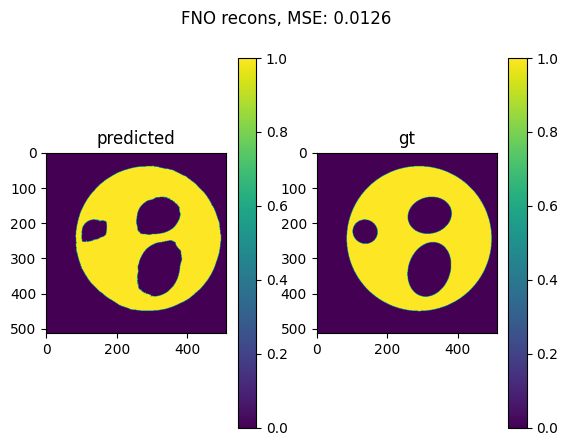

In [21]:
from models.fbps import FBP
from models.modelbase import evaluate_batches
fbp = FBP(model.geometry)
#Clear previous plots
for i in plt.get_fignums():
    plt.figure(i)
    plt.close()

VALIDATION_SINOS = geometry.project_forward(VALIDATION_PHANTOMS)
validation_la, known_angles_validation = geometry.zero_cropp_sinos(VALIDATION_SINOS, ar, 0)
exp_validation = extrapolate_fixpoint(validation_la, known_angles_validation, geometry, M, K, PolynomialFamily=Legendre, n_iters=100)
validation_la[:, ~known_angles_validation] = exp_validation[:, ~known_angles_validation]

disp_ind = 2
recons = model.forward(la_sino_batch, knwon_angles)
fig, mse = evaluate_batches((recons.detach()>0.5).to(float), phantom_batch, disp_ind, title="FNO recons")
print("validation loss:", mse)

mse: tensor(0.0794, device='cuda:0', dtype=torch.float64)


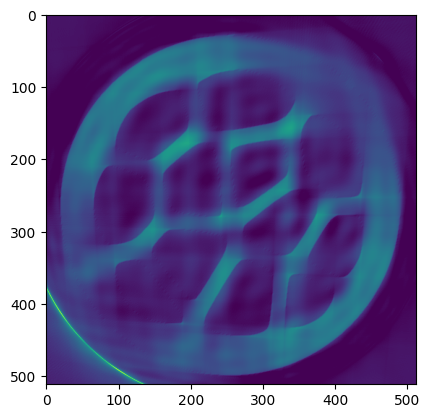

In [16]:
recons2 = torch.nn.functional.relu(geometry.fbp_reconstruct(validation_la))
plt.imshow(recons2[disp_ind].cpu())
print("mse:", MSE(recons2, VALIDATION_PHANTOMS))

In [9]:
#Save model
modelname = "fno_bp"
from models.modelbase import save_model_checkpoint
save_path = GIT_ROOT / "data" / "models" / (modelname + ".pt")
save_model_checkpoint(model, optimizer, loss, ar, save_path)
print("model saved to", save_path)

model saved to /home/emastr/deep-limited-angle/KEX---CT-reconstruction/data/models/fno_bp_fanbeamkits_ar0.25.pt
